In [2]:
using Revise
includet("Struct_types.jl")
includet("Deaton.jl")
includet("dpsolver.jl")


In [3]:
using .Deaton
using .dpsolver

In [69]:
using FastGaussQuadrature
using Distributions
using Interpolations
using LaTeXStrings
using Plots
using Random
pyplot();

In [5]:
dm = Deaton.deaton_model(β=.9, R=1.0, μ=1., σ=.1, η=2.,n_x=100)

Main.Deaton.deaton_model
  β: Float64 0.9
  R: Float64 1.0
  μ: Float64 1.0
  σ: Float64 0.1
  η: Float64 2.0
  xbar: Array{Float64}((2,)) [2.0e-16, 10.0]
  n_x: Int64 100
  n_c: Int64 100
  n_y: Int64 10
  integration: String "Hermite"
  x: Array{Float64}((100,)) [2.0e-16, 0.10101010101010122, 0.20202020202020224, 0.3030303030303032, 0.40404040404040426, 0.5050505050505053, 0.6060606060606063, 0.7070707070707073, 0.8080808080808084, 0.9090909090909094  …  9.09090909090909, 9.191919191919192, 9.292929292929292, 9.393939393939394, 9.494949494949495, 9.595959595959595, 9.696969696969697, 9.797979797979798, 9.8989898989899, 10.0]
  c: Array{Float64}((100, 100)) [2.0e-16 2.0e-16 … 2.0e-16 2.0e-16; 2.0e-16 0.001020304050607281 … 0.09998979695949414 0.10101010101010122; … ; 2.0e-16 0.09998979695949414 … 9.799000102030407 9.8989898989899; 2.0e-16 0.10101010101010122 … 9.8989898989899 10.0]
  quad: NamedTuple{(:y, :weights), Tuple{Vector{Float64}, Vector{Float64}}}


In [6]:

# V, c = dpsolver.vfi(m1, maxiter=1000, callback=dpsolver.iterinfo)
V, c = dpsolver.vfi_T(dm, 100);

In [7]:
function plot_solution(x,V,C)
    p1  =plot(x,V,xlabel=L"W",ylabel=L"V")
    p2 = plot(x,C,xlabel=L"W",ylabel=L"C")
    plot(p1,p2,layout =(1,2),legend=false, yguidefontrotation=-90)
end


plot_solution (generic function with 1 method)

In [8]:
function v_c_plot(x, V, c,ylim_V = (-8,10))
    """Illustrate solution"""
    N,T = size(V)
    
    p1  =plot()
    p2 = plot()
    for t in 2:T
        plot!(p1,x,V[:,t],alpha=0.25,linecolor=:grey)
        plot!(p2,x,c[:,t],alpha=0.25,linecolor=:grey)
    end
    plot!(p1,x,V[:,1],xlabel=L"W",ylabel=L"V",color=:red,ylim=ylim_V)
    plot!(p2,x,c[:,1],xlabel=L"W",ylabel=L"C")
    
    plot(p1,p2,layout =(1,2),legend=false, yguidefontrotation=-90)
end


v_c_plot (generic function with 2 methods)

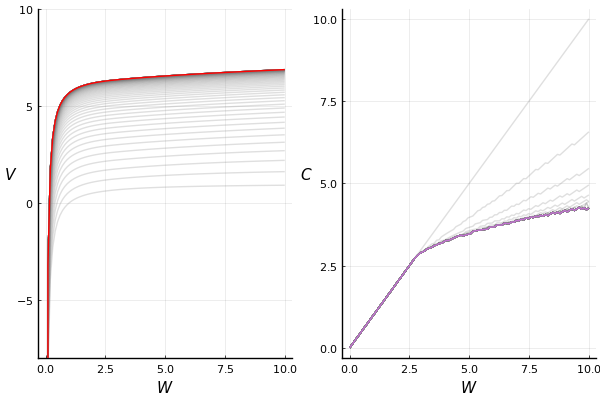

In [9]:
v_c_plot(dm.x,V,c)

In [10]:
m1=Deaton.deaton_model(β=.9, R=1.0, μ=1., σ=.1, η=2., xbar=[0, 10], n_x=100, n_c=200, n_y=10) 

Main.Deaton.deaton_model
  β: Float64 0.9
  R: Float64 1.0
  μ: Float64 1.0
  σ: Float64 0.1
  η: Float64 2.0
  xbar: Array{Int64}((2,)) [0, 10]
  n_x: Int64 100
  n_c: Int64 200
  n_y: Int64 10
  integration: String "Hermite"
  x: Array{Float64}((100,)) [0.0, 0.10101010101010102, 0.20202020202020204, 0.30303030303030304, 0.4040404040404041, 0.5050505050505051, 0.6060606060606061, 0.7070707070707071, 0.8080808080808082, 0.9090909090909092  …  9.09090909090909, 9.191919191919192, 9.292929292929292, 9.393939393939394, 9.494949494949495, 9.595959595959595, 9.696969696969697, 9.797979797979798, 9.8989898989899, 10.0]
  c: Array{Float64}((100, 200)) [0.0 0.0 … 0.0 0.0; 0.0 0.0005075884472869398 … 0.10050251256281408 0.10101010101010102; … ; 0.0 0.0497436678341201 … 9.84924623115578 9.8989898989899; 0.0 0.05025125628140704 … 9.949748743718592 10.0]
  quad: NamedTuple{(:y, :weights), Tuple{Vector{Float64}, Vector{Float64}}}


In [11]:
V_inf, c_inf = dpsolver.vfi(m1);

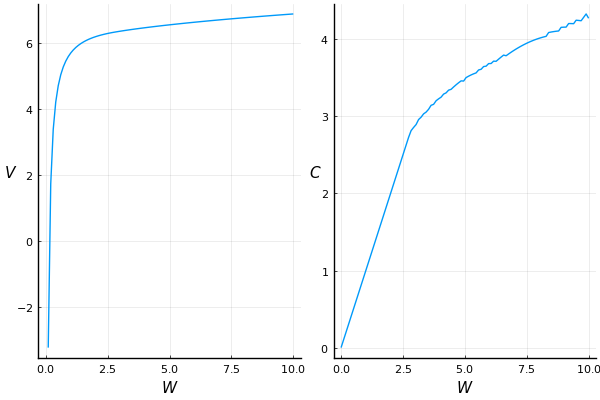

In [12]:
plot_solution(m1.x,V_inf,c_inf)

In [72]:
Random.seed!()

MersenneTwister(0xbb2042bda3a54421c81ef1d86cbfc400)

In [92]:
function simulate(dm::Deaton.deaton_model,Tsim::Int64=99,T::Int64=100,A0=0,seed=123)
    Random.seed!(seed)
    
    V, c = dpsolver.vfi_T(dm,T)
    x = dm.x
    
    c_t = Array{Float64}(undef,Tsim)
    x_t = Array{Float64}(undef,Tsim)
    c_t = Array{Float64}(undef,Tsim)
    y_t = exp.(rand(Normal(dm.μ,dm.σ), Tsim))
    x_t[1] = A0 +y_t[1]
    
    for t = 1:1:Tsim
        
        c_interp = LinearInterpolation(x,c[:,t],extrapolation_bc=Periodic())
        
        
        c_t[t] = c_interp(x_t[t])
        
        if t<Tsim
            x_t[t+1] = dm.R .* (x_t[t] .- c_t[t]) .+ y_t[t+1]
        end
    end
    
    return y_t, x_t, c_t
end

simulate (generic function with 5 methods)

  1.229186 seconds (49.66 k allocations: 464.097 MiB, 2.09% gc time)


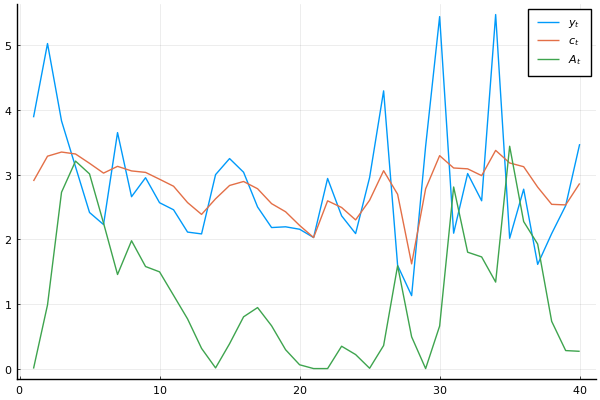

In [104]:
m1 = Deaton.deaton_model(β=.95, R=1.0, μ=1., σ=.3, η=2., xbar=[0, 20], n_x=100, n_c=200, n_y=3)
Tsim = 40
@time y_t, x_t, c_t = simulate(m1, Tsim, 500, 0)

p1 = plot(1:1:Tsim, y_t, label=L"y_{t}")
plot!(p1,1:1:Tsim, c_t, label=L"c_{t}")
plot!(p1,1:1:Tsim, x_t.-y_t, label=L"A_{t}")

  1.280271 seconds (49.75 k allocations: 465.025 MiB, 2.00% gc time)


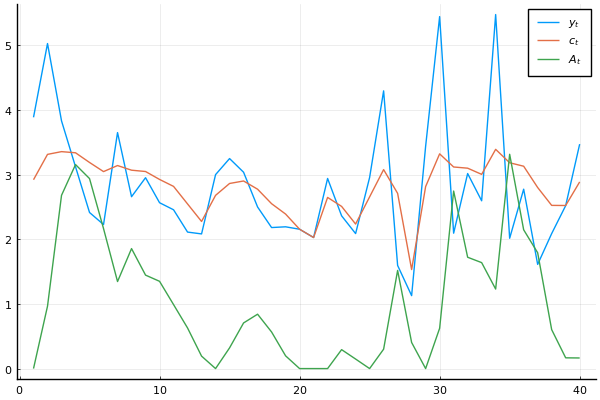

In [98]:
m1 = Deaton.deaton_model(β=.95, R=1.0, μ=1., σ=.3, η=2., xbar=[0, 20], n_x=100, n_c=200, n_y=3,integration="Legendre")
Tsim = 40
@time y_t, x_t, c_t = simulate(m1, Tsim, 501, 0,)

p1 = plot(1:1:Tsim, y_t, label=L"y_{t}")
plot!(p1,1:1:Tsim, c_t, label=L"c_{t}")
plot!(p1,1:1:Tsim, x_t.-y_t, label=L"A_{t}")